In [1]:
import numpy as np
import os

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set_palette('Set1', 10, desat=0.75)

import pandas as pd
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 200)

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = 'data/'
data = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
kagg = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
data.columns = ['id', 'qid1', 'qid2', 'q1', 'q2', 'target']
kagg.columns = ['test_id', 'q1', 'q2']

In [3]:
data.head(5)

,id,qid1,qid2,q1,q2,target
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [4]:
kagg.head()

,test_id,q1,q2
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?
2,2,What but is the best way to send money from China to the US?,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
print ('Total question pairs in train and test: {}, {}'
       .format(data.shape[0], kagg.shape[0]))
print ('Total number of empty questions in train and test: {}, {}'
       .format(data.shape[0]-data.dropna().shape[0], 
               kagg.shape[0]-kagg.dropna().shape[0]))
print ('There are {} unique questions in train out of total {}'
       .format(len(set(data.q2.tolist() + data.q1.tolist())), data.shape[0]*2))
print ('There are {} unique questions in test out of total {}'
       .format(len(set(kagg.q2.tolist() + kagg.q1.tolist())), kagg.shape[0]*2))

data.fillna('', inplace=True)
kagg.fillna('', inplace=True)

Total question pairs in train and test: 404290, 2345796
Total number of empty questions in train and test: 2, 6
There are 537362 unique questions in train out of total 808580
There are 4363832 unique questions in test out of total 4691592


## questions analysis

Here we can see that many questions in test are indeed artificially generated. Also in train there are diffirent top questions in q1 and q2. There might be some structure.

In [6]:
top_to_show = 5
columns = ['q1', 'q2']

for column in columns:
    print ('Most frequent quesitons in train data in column {}:'.format(column))
    print (data[column].value_counts()[:top_to_show], '\n')
    
for column in columns:
    print ('Most frequent quesitons in test data in column {}:'.format(column))
    print (kagg[column].value_counts()[:top_to_show], '\n')

Most frequent quesitons in train data in column q1:
How do I improve my English speaking?                                                         50
How does the ban on 500 and 1000 rupee notes helps to identify black money and corruption?    48
How can changing 500 and 1000 rupee notes end the black money in India?                       47
How do I improve my English language?                                                         47
What should I do to earn money online?                                                        47
Name: q1, dtype: int64 

Most frequent quesitons in train data in column q2:
How can you look at someone's private Instagram account without following them?       120
What are the best ways to lose weight?                                                119
How can I lose weight quickly?                                                        100
What's the easiest way to make money online?                                           71
What are some things new e

It also looks like questions in q2 column are more frequent that ones in q1. Let's plot the histogram to check it

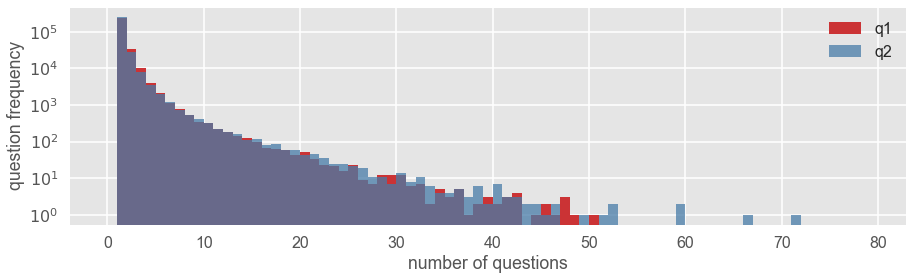

In [8]:
plt.figure(figsize=(15,4))
plt.hist(data.q1.value_counts(), bins=np.arange(0,80,1))
plt.hist(data.q2.value_counts(), bins=np.arange(0,80,1), alpha=0.75)

plt.legend(['q1', 'q2'])
plt.xlabel('number of questions')
plt.ylabel('question frequency')
plt.yscale('log')
plt.show()

Well, we were wrong. Question's frequencies distributed equally. Let's check the distribution of question lengths in characters and words (cut by 300 characters max). Also Quora has limit of 150 character per questions in most cases.

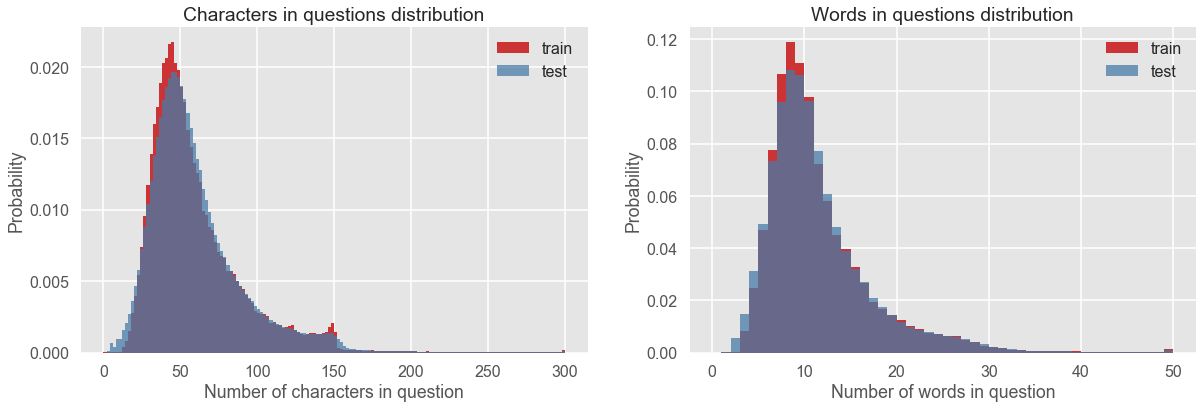

CPU times: user 19.3 s, sys: 445 ms, total: 19.7 s
Wall time: 19.8 s


In [12]:
%%time
train_corpus = pd.Series(data['q1'].tolist() + data['q2'].tolist())
test_corpus  = pd.Series(kagg['q1'].tolist() + kagg['q2'].tolist()) 

fig, ax = plt.subplots(1, 2, figsize=(20,6))

max_chars = 300
bin_width = 2
ax[0].hist(train_corpus.astype(str).apply(lambda q: min(len(q), max_chars)), 
           bins = np.arange(0, max_chars+bin_width, bin_width), normed=True)
ax[0].hist(test_corpus .astype(str).apply(lambda q: min(len(q), max_chars)), 
           bins = np.arange(0, max_chars+bin_width, bin_width), normed=True, alpha = 0.75)
ax[0].set_title('Characters in questions distribution')
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Number of characters in question')
ax[0].legend(['train', 'test'])

max_words = 50
ax[1].hist(train_corpus.astype(str).apply(lambda q: min(len(q.split(' ')),max_words)), 
           bins = np.arange(0, max_words+1, 1), normed=True)
ax[1].hist(test_corpus .astype(str).apply(lambda q: min(len(q.split(' ')),max_words)), 
           bins = np.arange(0, max_words+1, 1), normed=True, alpha=0.75)
ax[1].set_title('Words in questions distribution')
ax[1].set_ylabel('Probability')
ax[1].set_xlabel('Number of words in question')
ax[1].legend(['train', 'test'])

plt.show()

No surpises here. Test is slightly diffirenet, probably thanks to aritficially generated pairs.

## Target exploration and non-NLP predictive features

Let's look at the correlations

In [13]:
print ('target avg: {:.3f}'.format(data.target.mean()))
data.corr()

target avg: 0.369


,id,qid1,qid2,target
id,1.000000,0.629373,0.641993,-0.008784
qid1,0.629373,1.000000,0.700140,-0.247072
qid2,0.641993,0.700140,1.000000,-0.260101
target,-0.008784,-0.247072,-0.260101,1.000000


Wow! That's rather high correlation of target variable with ids! Let's plot it to figure it out

In [14]:
data["qmax"] = data.apply(lambda row: max(row["qid1"], row["qid2"]), axis=1)
data["qmin"] = data.apply(lambda row: min(row["qid1"], row["qid2"]), axis=1)
data["qavg"] = data.apply(lambda row: np.mean([row["qid1"], row["qid2"]]), axis=1)

id correlation with target: -0.009
qid1 correlation with target: -0.26
qid2 correlation with target: -0.27
qavg correlation with target: -0.29
qmax correlation with target: -0.267
qmin correlation with target: -0.282


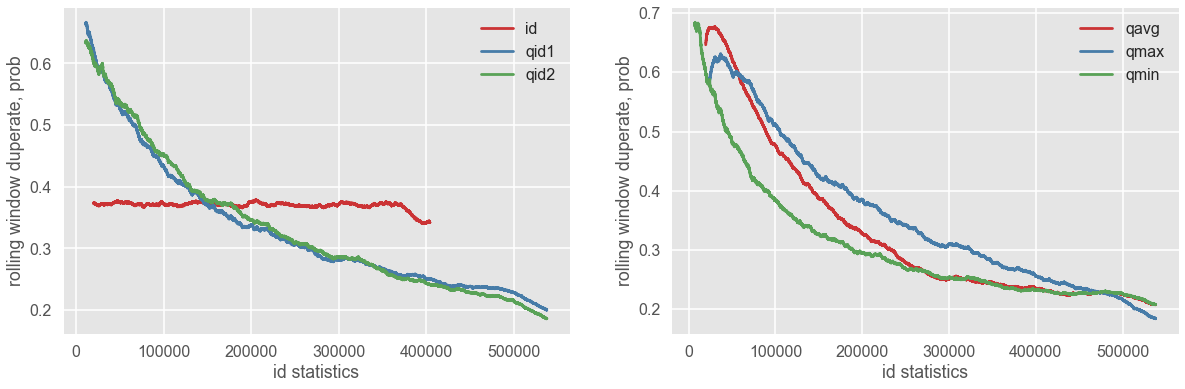

In [15]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
graph_number = 0

for feature in ['id', 'qid1', 'qid2','qavg', 'qmax', 'qmin']:
    data_temp = data.sort_values(by=[feature], ascending=True)
    data_temp["dupe_rate"] = data_temp.target.rolling(window=20000, min_periods=20000).mean()

    print (feature, 'correlation with target:', round(data_temp[[feature, 'target']].corr(method='spearman').iloc[0][1], 3))
    axs[graph_number//3].plot(data_temp[feature], data_temp["dupe_rate"], label=feature)
    graph_number+=1
    
for ax in axs:
    ax.legend()
    ax.set_xlabel('id statistics')
    ax.set_ylabel('rolling window duperate, prob')
plt.show()

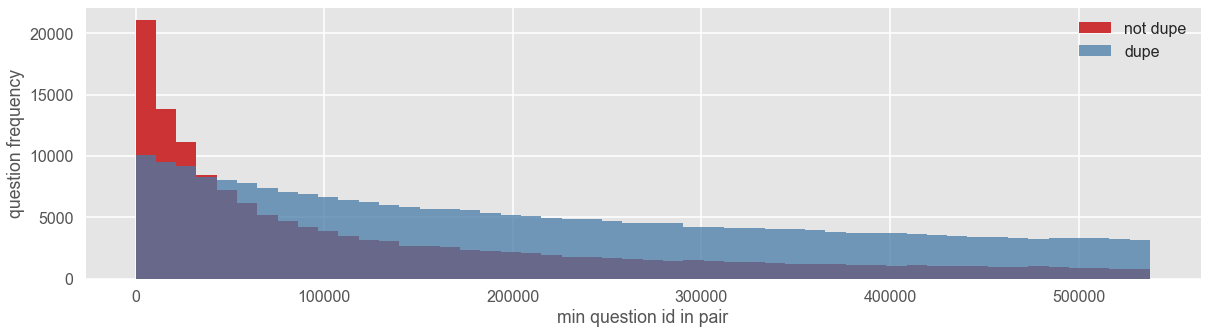

In [16]:
plt.figure(figsize=(20,5))
plt.hist(data[data['target']==1].qmin, bins=50)
plt.hist(data[data['target']==0].qmin, bins=50, alpha=0.75)
plt.legend(['not dupe', 'dupe'])
plt.xlabel('min question id in pair')
plt.ylabel('question frequency')
plt.ylim(0)

plt.show()

There is a strong evidence of correlation between ids and avg target in rolling window. Interestingly the higher the id, the less probability of duplicate. It might hae to do something with Quora algorithms of pair selection. Let's assume that newer questions get higher ids. That means if question has higher id, we might not see it often in dataset (since it's new). So if we count all the questions, there should be strong correlation between target and number of question appearences.

In [17]:
count_dict = train_corpus.value_counts().to_dict()
data["q1_counts"] = data.q1.apply(lambda q: count_dict[q])
data["q2_counts"] = data.q2.apply(lambda q: count_dict[q])
data[['target', 'q1_counts', 'q2_counts', 'qmin']].corr()

,target,q1_counts,q2_counts,qmin
target,1.000000,0.358253,0.274466,-0.253369
q1_counts,0.358253,1.000000,0.629018,-0.380983
q2_counts,0.274466,0.629018,1.000000,-0.357922
qmin,-0.253369,-0.380983,-0.357922,1.000000


Bingo. Counts have correlation even higher than ids. Wierdly, counts of second qestion correlated with target much lower compating to first question counts. Let's see how theese two kind of counts are related.

In [18]:
colors = sns.color_palette()
data['color'] = [colors[0] if target==1 else colors[1] for target in data.target]

import matplotlib.patches as mpatches
dupe_patch = mpatches.Patch(color=colors[0], label='dupe')
not_dupe_patch = mpatches.Patch(color=colors[1], label='not dupe')

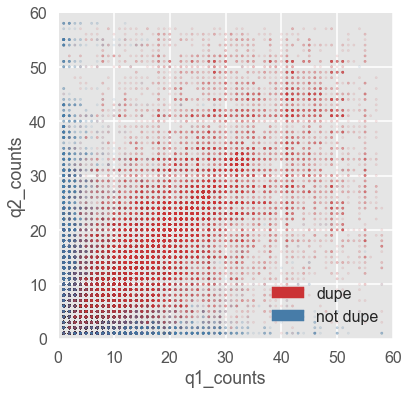

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(data.q1_counts, data.q2_counts, s=5, alpha=0.1, c=data.color) #15
plt.legend(handles=[dupe_patch, not_dupe_patch])
plt.xlabel('q1_counts')
plt.ylabel('q2_counts')
plt.xlim(0,60)
plt.ylim(0,60)
plt.show()

That picture not very clear, because counts are integers and many datapoints are plotted in the same positions. Let's add a bit of uniform noise from [-0.5; 0.5] to make things clearer

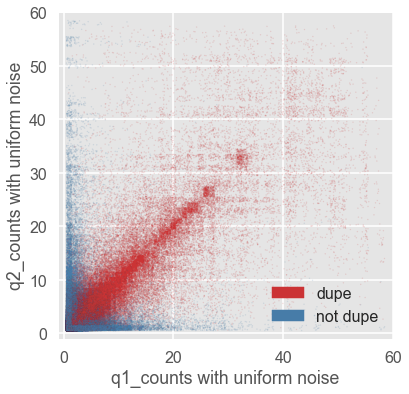

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(data.q1_counts+np.random.uniform(low=-0.5, high=0.5, size=data.shape[0]), 
            data.q2_counts+np.random.uniform(low=-0.5, high=0.5, size=data.shape[0]),
            alpha=0.1, s=1, c=data.color)
plt.legend(handles=[dupe_patch, not_dupe_patch])
plt.xlabel('q1_counts with uniform noise')
plt.ylabel('q2_counts with uniform noise')
plt.xlim(-1,60)
plt.ylim(-1,60)
plt.show()

From graphs it looks like feature min(q1_counts, q2_counts) will have significantly higher predictive power. Let's try it and check the correlation

In [21]:
data["counts_min"] = data.apply(lambda row: min(row["q1_counts"], row["q2_counts"]), axis=1)
data[['target', 'q1_counts', 'q2_counts', 'qmin', 'counts_min']].corr()

,target,q1_counts,q2_counts,qmin,counts_min
target,1.000000,0.358253,0.274466,-0.253369,0.417834
q1_counts,0.358253,1.000000,0.629018,-0.380983,0.889017
q2_counts,0.274466,0.629018,1.000000,-0.357922,0.737573
qmin,-0.253369,-0.380983,-0.357922,1.000000,-0.363477
counts_min,0.417834,0.889017,0.737573,-0.363477,1.000000


We got an 0.07 boost in correlation! 

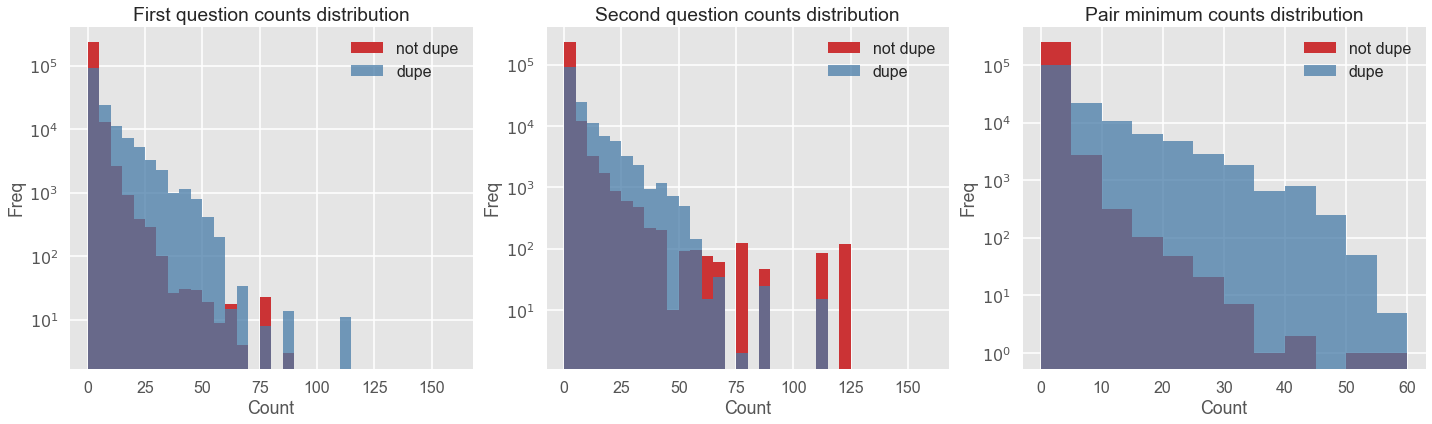

In [26]:
fig, axs = plt.subplots(1,3, figsize=(20,6))#, sharey=True)
graph_number = 0

for feature in ['q1_counts', 'q2_counts', 'counts_min']:
    axs[graph_number].hist(data[data['target']==0][feature], bins=np.arange(0, data[feature].max()+5, 5))
    axs[graph_number].hist(data[data['target']==1][feature], bins=np.arange(0, data[feature].max()+5, 5), alpha=0.75)
    axs[graph_number].legend(['not dupe', 'dupe'])
    axs[graph_number].set_xlabel('Count')
    axs[graph_number].set_ylabel('Freq')
    axs[graph_number].set_yscale('log')
    graph_number+=1

axs[0].set_title('First question counts distribution')
axs[1].set_title('Second question counts distribution')
axs[2].set_title('Pair minimum counts distribution')

plt.tight_layout()
plt.show()

Histogram with min count value looks way better than two others.  Also we could see there is a strong negative correlation between qmin and counts in correlation table. Let's plot it. Uniformly distributed noise is added to make plot smoother.

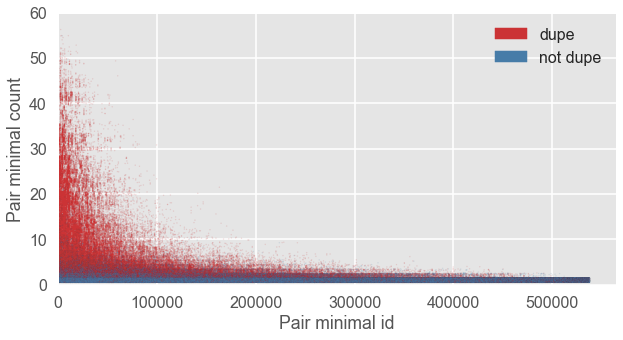

In [27]:
plt.figure(figsize=(10,5))
plt.scatter(data.qmin,
            data.counts_min + np.random.uniform(low=-0.5, high=0.5, size=data.shape[0]), 
            s=1, alpha=0.1, c=data.color)
plt.legend(handles=[dupe_patch, not_dupe_patch])
plt.xlabel('Pair minimal id')
plt.ylabel('Pair minimal count')
plt.xlim(0)
plt.ylim(0,60)
plt.show()

Graph clearly shows that questions with higher id tend to have much lower frequency. Let's put the correlations between target and id into another perspective - we'll plot pair's consecutive number in dataset vs qid_min with target shown in different colors.

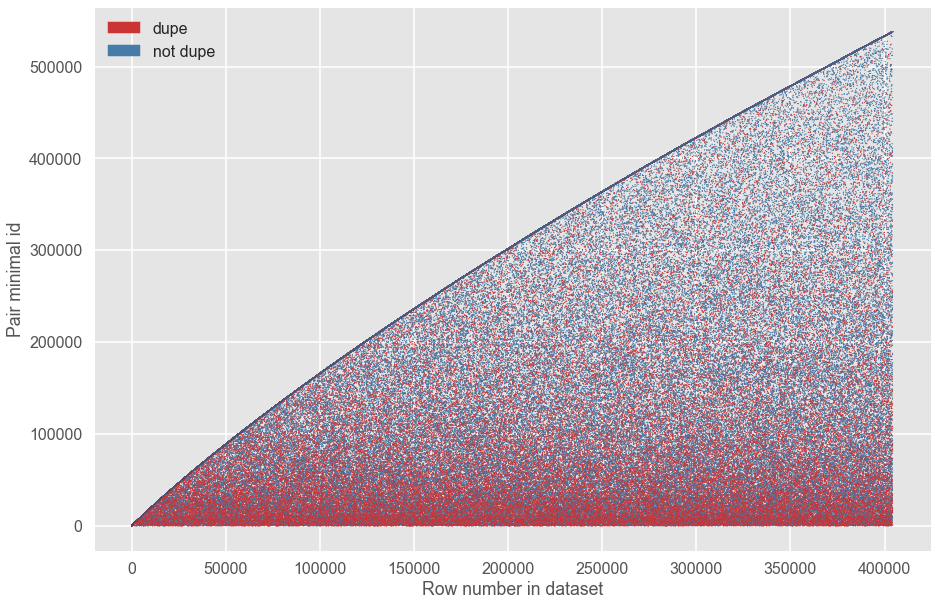

In [28]:
plt.figure(figsize=(15,10))
plt.scatter(range(data.shape[0]), data.qmin, s=0.5, c=data.color)
plt.xlabel('Row number in dataset')
plt.ylabel('Pair minimal id')
plt.legend(handles=[dupe_patch, not_dupe_patch])

plt.show()

## Question graphs

Imagine that we have approx 10k of unique categories (themes) for Qoura questions (rather low number by the way). We also have 540k of unique questions in train dataset. That means, that there are about 54 questiosn per each category. We have 400k pairs constructed from theese questions in train dataset. Let's imagine that theese pairs were chosen randomly. What will be the average duplicate rate in the whole dataset?

The same as probabilty for one pair: (54-1)/54,000 = 0.001. But as we know, avg duplicate rate in constructed dataset equals to 0.37. It's 370 times more than we expected! That only can be explained by the fact, that our dataset was constructed in strongly non-random way. The sole fact of connection between questions (connection == seen them as a pair) is a very strong evidence towards probability of the duplicates. For example if pair A-B presents in dataset along with B-C, that is a strong evidence that questions A-C are duplicates, even if A-B and B-C are not!

In [29]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(data['qid1'])
G.add_nodes_from(data['qid2'])
edges = list(data[['qid1', 'qid2']].to_records(index=False))
G.add_edges_from(edges)

graph_dict = dict()
graph_id = 1
for i in range(1,len(G)+1):
    graph = G[i]
    if i not in graph_dict:
        graph_dict[i] = graph_id
    for qid in graph:
        if qid not in graph_dict:
            graph_dict[qid] = graph_id
    graph_id+=1
    
print (len(set(graph_dict.values())))  
data['graph_id'] = data.qid1.apply(lambda x: graph_dict[x])

250103


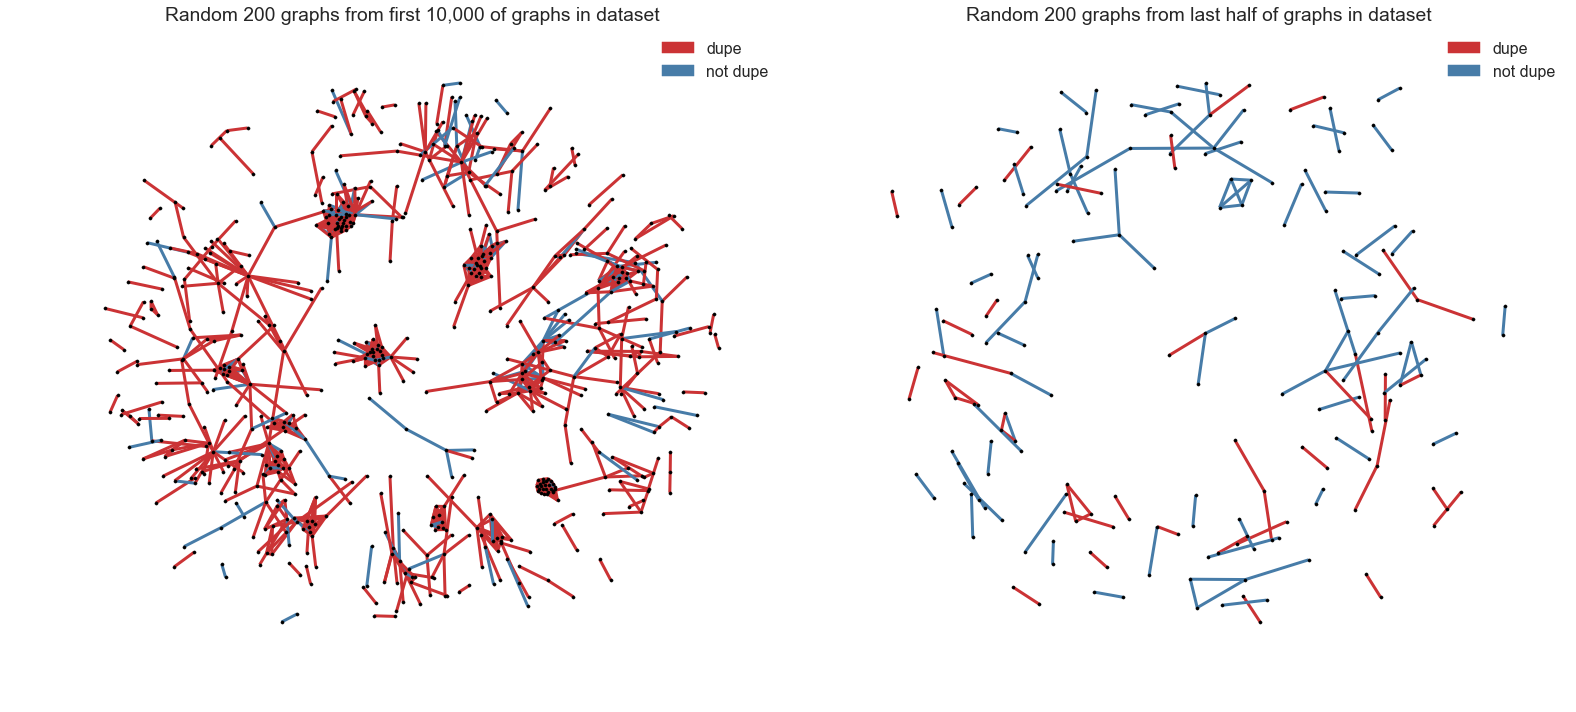

In [299]:
plt.figure(figsize=(22,10))

tempdata = data[data['graph_id'].isin(np.random.choice(np.arange(0, 1e4), 200, replace=False))]
edge_colors = tempdata['color'].tolist()
subG = nx.Graph()
subG.add_nodes_from(tempdata['qid1'].tolist() + tempdata['qid2'].tolist())
edges = list(tempdata[['qid1', 'qid2']].to_records(index=False))
subG.add_edges_from(edges)
positions = nx.spring_layout(subG, iterations=30, k=0.075)

plt.subplot(1,2,1)
nx.draw_networkx_nodes(subG, positions, node_color='black', node_size=10)
nx.draw_networkx_edges(subG, positions, width=3, alpha=1, edge_color=edge_colors )
plt.legend(handles=[dupe_patch, not_dupe_patch])
plt.title('Random 200 graphs from first 10,000 of graphs in dataset')
plt.axis('off')


tempdata = data[data['graph_id'].isin(np.random.choice(np.arange(1e5, 2e5), 200, replace=False))]
edge_colors = tempdata['color'].tolist()
subG = nx.Graph()
subG.add_nodes_from(tempdata['qid1'].tolist() + tempdata['qid2'].tolist())
edges = list(tempdata[['qid1', 'qid2']].to_records(index=False))
subG.add_edges_from(edges)

plt.subplot(1,2,2)
positions = nx.spring_layout(subG, iterations=10, k=0.05)
nx.draw_networkx_nodes(subG, positions, node_color='black', node_size=10)
nx.draw_networkx_edges(subG, positions, width=3, alpha=1, edge_color=edge_colors )
plt.legend(handles=[dupe_patch, not_dupe_patch])
plt.title('Random 200 graphs from last half of graphs in dataset')
plt.axis('off')

plt.tight_layout()
plt.show()

We can clearly see, that graphs in the beginning tend to be broader, with higher number of nodes. On the other hand, graphs from the second half of dataset rarely have more than 3 nodes and mainly are not duplicates. Also, almost all big subgraphs consist from duplicate questions.

Let's build two features: number of common neighbors for each question and share of common neighbors. I expect it be powerful features.

In [30]:
from collections import defaultdict

neighbors_dict = defaultdict(set)
for i in range(data.shape[0]):
    neighbors_dict[data.q1[i]].add(data.q2[i])
    neighbors_dict[data.q2[i]].add(data.q1[i])

In [31]:
def get_q1_q2_neighbors_count(q1,q2):
    q1_neighbors = neighbors_dict[q1]
    q2_neighbors = neighbors_dict[q2]
    return len(q1_neighbors.intersection(q2_neighbors))

def get_q1_q2_neighbors_share(q1,q2):
    q1_neighbors = neighbors_dict[q1]
    q2_neighbors = neighbors_dict[q2]
    return 2.*len(q1_neighbors.intersection(q2_neighbors))/(len(q1_neighbors) + len(q2_neighbors))

data['neighbor_count'] = data.apply(lambda row: get_q1_q2_neighbors_count(row.q1, row.q2), axis=1)
data['neighbor_share'] = data.apply(lambda row: get_q1_q2_neighbors_share(row.q1, row.q2), axis=1)

In [32]:
data[['target', 'neighbor_count', 'neighbor_share']].corr()

,target,neighbor_count,neighbor_share
target,1.000000,0.432961,0.649123
neighbor_count,0.432961,1.000000,0.730279
neighbor_share,0.649123,0.730279,1.000000


Correlation of 0.65! That is way better than anything we did before.


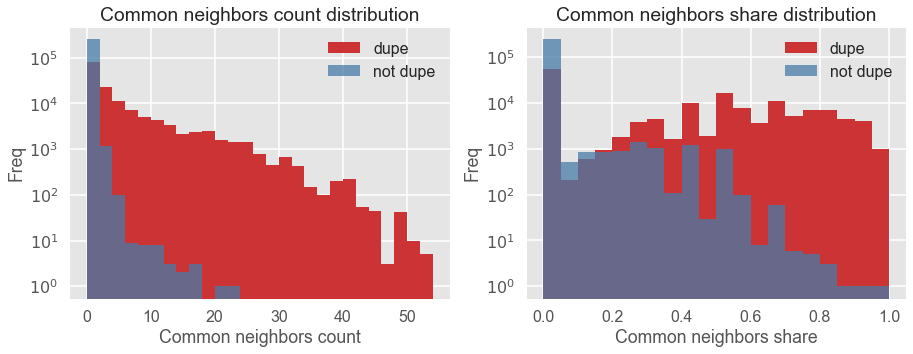

In [37]:
plt.subplots(1,2, figsize=(15,5))

plt.subplot(1,2,1)
bin_width = 2
plt.hist(data[data.target==1].neighbor_count, 
         bins=np.arange(0, data.neighbor_count.max()+bin_width, bin_width))
plt.hist(data[data.target==0].neighbor_count, 
         bins=np.arange(0, data.neighbor_count.max()+bin_width, bin_width), alpha=0.75)
plt.yscale('log')
plt.legend(['dupe', 'not dupe'])
plt.xlabel('Common neighbors count')
plt.ylabel('Freq')
plt.title('Common neighbors count distribution')

plt.subplot(1,2,2)
bin_width = 0.05
plt.hist(data[data.target==1].neighbor_share, 
         bins=np.arange(0, data.neighbor_share.max()+bin_width, bin_width))
plt.hist(data[data.target==0].neighbor_share, 
         bins=np.arange(0, data.neighbor_share.max()+bin_width, bin_width), alpha=0.75)
plt.yscale('log')
plt.legend(['dupe', 'not dupe'])
plt.xlabel('Common neighbors share')
plt.ylabel('Freq')
plt.title('Common neighbors share distribution')

plt.show()

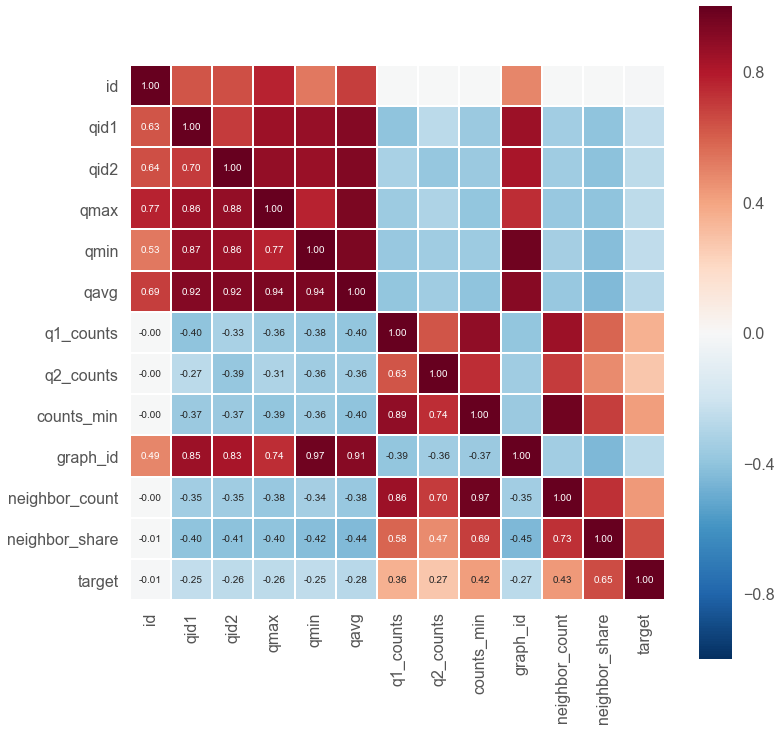

In [38]:
plt.figure(figsize=(12,12))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask, 1)] = True
corr_columns = list(data.drop('target', axis=1).columns) + ['target'] #move 'target' to the end of df
sns.heatmap(data[corr_columns].corr(), square=True, cbar=False)
sns.heatmap(data[corr_columns].corr(), square=True, mask=mask, annot=True, fmt='.2f', linewidths=1)

plt.show()

We seem to have features with strong target correlation. Nevertheless, many features are pairwise correlated. Later we'll deal with it. We will not save theese features now. They  will be generated in notebook *5_nonNLP_features* along with more complicated ones.